This notebook provides a visualisation of the raw data for the monoisotope, and shows the curve that was fitted to find the RT apex.
It relies on the following files from BAM:
- scp -i ~/Documents/AWS\ keys/dwm-protlab.pem ubuntu@3.211.113.236:~/experiments/dwm-test/target-decoy-models/experiment-metrics-for-library-sequences.pkl ~/Downloads/experiments/dwm-test/target-decoy-models/

Note that sequences_metrics_df contains unclassified features - it may contain features classified as decoys from particular runs. In this notebook we rely on the 'analyse the isotope intensity adjustment by peptide' notebook to identify sequences of interest in particular runs.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json

In [2]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
TEMP_DIR = '/home/ubuntu'

In [3]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [4]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)


In [5]:
run_name = '190719_Hela_Ecoli_1to3_02'
file_idx = file_idx_for_run(run_name)

In [6]:
selected_sequence = 'NPNVTSVEHVVVLK'
selected_sequence_charge = 2

In [7]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
selected_sequence_s = pd.read_sql_query('select * from features where file_idx=={} and sequence==\'{}\' and charge=={}'.format(file_idx,selected_sequence,selected_sequence_charge), db_conn).iloc[0]
db_conn.close()

In [8]:
mono_raw_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_raw_points_l), columns=['retention_time_secs','intensity'])
mono_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.mono_filtered_points_l))
isotope_1_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_1_filtered_points_l))
isotope_2_filtered_points_df = pd.DataFrame(json.loads(selected_sequence_s.isotope_2_filtered_points_l))

In [10]:
mono_rt_lower,mono_rt_upper = json.loads(selected_sequence_s.mono_rt_bounds)
mono_isolated_peak_df = mono_filtered_points_df[(mono_filtered_points_df.x >= mono_rt_lower) & (mono_filtered_points_df.x <= mono_rt_upper)]
mono_rt_apex_derived = selected_sequence_s.rt_apex
# mono_rt_apex_estimated = selected_peak_df.target_coords['rt_apex']

In [11]:
isotope_1_rt_lower,isotope_1_rt_upper = json.loads(selected_sequence_s.isotope_1_rt_bounds)
isotope_1_isolated_peak_df = isotope_1_filtered_points_df[(isotope_1_filtered_points_df.x >= isotope_1_rt_lower) & (isotope_1_filtered_points_df.x <= isotope_1_rt_upper)]

In [12]:
isotope_2_rt_lower,isotope_2_rt_upper = json.loads(selected_sequence_s.isotope_2_rt_bounds)
isotope_2_isolated_peak_df = isotope_2_filtered_points_df[(isotope_2_filtered_points_df.x >= isotope_2_rt_lower) & (isotope_2_filtered_points_df.x <= isotope_2_rt_upper)]

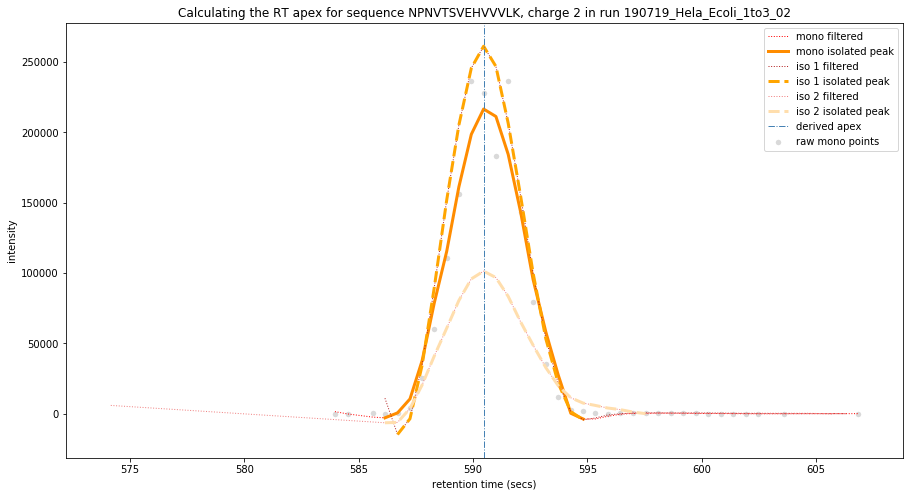

In [13]:
f, ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)
plt.margins(0.06)

title = 'Calculating the RT apex for sequence {}, charge {} in run {}'.format(selected_sequence, selected_sequence_charge, run_name)
plt.title(title)

ax.scatter(mono_raw_points_df.retention_time_secs, mono_raw_points_df.intensity, marker='o', color='silver', lw=0, s=30, alpha=0.6, label='raw mono points')

# isotope 0
ax.plot(mono_filtered_points_df.x, mono_filtered_points_df.filtered_intensity, marker='', color='red', linestyle=':', linewidth=1, ms=5, label='mono filtered')
ax.plot(mono_isolated_peak_df.x, mono_isolated_peak_df.filtered_intensity, marker='', color='darkorange', linestyle='-', linewidth=3, ms=5, label='mono isolated peak')

# isotope 1
ax.plot(isotope_1_filtered_points_df.x, isotope_1_filtered_points_df.filtered_intensity, marker='', color='firebrick', linestyle=':', linewidth=1, ms=5, label='iso 1 filtered')
ax.plot(isotope_1_isolated_peak_df.x, isotope_1_isolated_peak_df.filtered_intensity, marker='', color='orange', linestyle='--', linewidth=3, ms=5, label='iso 1 isolated peak')

# isotope 2
ax.plot(isotope_2_filtered_points_df.x, isotope_2_filtered_points_df.filtered_intensity, marker='', color='lightcoral', linestyle=':', linewidth=1, ms=5, label='iso 2 filtered')
ax.plot(isotope_2_isolated_peak_df.x, isotope_2_isolated_peak_df.filtered_intensity, marker='', color='navajowhite', linestyle='--', linewidth=3, ms=5, label='iso 2 isolated peak')

ax.axvline(mono_rt_apex_derived, color='steelblue', lw=1.0, ls='-.', label='derived apex')
# ax.axvline(mono_rt_apex_estimated, color='limegreen', lw=1.0, ls='-.', label='estimated apex')

plt.legend(loc='best')
plt.xlabel('retention time (secs)')
plt.ylabel('intensity')

plt.show()